In [1]:
import glob
import pickle

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tqdm
from scipy.stats import sem
from scipy.stats import ttest_ind

from experiments.end_to_end.proof_node import ErrorNode
from experiments.end_to_end.proof_node import InternalNode




In [3]:
paths = {
    # 'bestfs': glob.glob("../runs/minif2f/minif2f_bestfs/2024_07_31/16_28_47/traces/0/*"),
    'bestfs_8_top': glob.glob("../runs/minif2f/bestfs_topk-k8-rFalse/2024_08_20/16_19_27/traces/0/*"),
    'bestfs_8_random': glob.glob("../runs/minif2f/bestfs_topk-k8-rTrue/2024_08_21/08_45_42/traces/0/*"),
    'bestfs_16_top': glob.glob("../runs/minif2f/bestfs_topk-k16-rFalse/2024_08_21/22_44_33/traces/0/*"),
    'bestfs_16_random': glob.glob("../runs/minif2f/bestfs_topk-k16-rTrue/2024_08_22/12_32_56/traces/0/*"),
    'bestfs_32_top': glob.glob("../runs/minif2f/bestfs_topk-k32-rFalse/2024_08_22/10_11_13/traces/0/*"),
    'bestfs_32_random': glob.glob("../runs/minif2f/bestfs_topk-k32-rTrue/2024_08_22/22_06_14/traces/0/*"),


    # 'k8_e0.5': glob.glob("../runs/minif2f/fixed_combined-k8-e0.5/2024_08_30/10_11_23/traces/0/*"),
    # 'k32_e0.5': glob.glob("../runs/minif2f/fixed_combined-k32-e0.5/2024_09_03/03_06_56/traces/0/*"),
    # 'k16_e0.5': glob.glob("../runs/minif2f/fixed_combined-k16-e0.5/2024_09_01/10_38_04/traces/0/*"),

    'k8_e0.1': glob.glob('../runs/minif2f/fixed_combined-k8-e0.1/2024_08_26/15_49_54/traces/0/*'),
    'k32_e0.1': glob.glob("../runs/minif2f/fixed_combined-k32-e0.1/2024_08_29/17_42_42/traces/0/*"),
    'k16_e0.1': glob.glob("../runs/minif2f/fixed_combined-k16-e0.1/2024_08_28/16_04_20/traces/0/*"),
    
    'k8_t1': glob.glob("../runs/minif2f/time_ablation-k8/2024_09_23/14_44_44/traces/0/*"),
    'k16_t1': glob.glob("../runs/minif2f/time_ablation-k16/2024_09_25/14_21_15/traces/0/*"),
    'k32_t1': glob.glob("../runs/minif2f/time_ablation-k32/2024_09_26/18_46_33/traces/0/*"),

    'k8_theta4': glob.glob("../runs/minif2f/temp_ablation-k8/2024_09_25/10_06_32/traces/0/*"),
    'k16_theta4': glob.glob("../runs/minif2f/temp_ablation-k16/2024_09_24/07_08_43/traces/0/*"),
    'k32_theta4': glob.glob("../runs/minif2f/temp_ablation-k32/2024_09_23/14_45_18/traces/0/*"),
    
    # 'k16': glob.glob("../runs/minif2f/fixed_no_score-k16/2024_08_28/16_02_42/traces/0/*"),
    # 'k8': glob.glob("../runs/minif2f/fixed_no_score-k8/2024_08_26/15_54_16/traces/0/*"),
    # 'k32': glob.glob("../runs/minif2f/fixed_no_score-k32/2024_08_29/17_51_47/traces/0/*"),
}



In [4]:
def get_unique_children(node):
    # get valid tactics:
    valid_tactics = set()
    seen = set()
    for response in node.out_edges:
        result = response.dst

        for result_node in result:
            if isinstance(result_node,
                          InternalNode) and result_node not in seen:
                seen.add(result_node)
                tac = (response.tactic, response.tac_logprob)
                if tac not in valid_tactics:
                    valid_tactics.add(tac)

    num_valid = len([d.dst[0] for d in node.out_edges if
                     node.out_edges and not isinstance(d.dst[0], ErrorNode)])

    if num_valid > 0:
        return len(valid_tactics) / num_valid
    else:
        return None


def get_unique_responses(node):
    # get valid tactics:
    valid_tactics = set()
    seen = set()
    for response in node.out_edges:
        result = response.dst

        for result_node in result:
            if isinstance(result_node,
                          InternalNode) and result_node not in seen:
                seen.add(result_node)
                tac = (response.tactic, response.tac_logprob)
                if tac not in valid_tactics:
                    valid_tactics.add(tac)
            elif isinstance(result_node, ErrorNode) and result_node.inner.message not in seen:
                seen.add(result_node.inner.message)
                tac = (response.tactic, response.tac_logprob)
                if tac not in valid_tactics:
                    valid_tactics.add(tac)

    return len(valid_tactics)

def get_unique_children_total(node):
    # get valid tactics:
    valid_tactics = set()
    seen = set()
    for response in node.out_edges:
        result = response.dst

        for result_node in result:
            if isinstance(result_node,
                          InternalNode) and result_node not in seen:
                seen.add(result_node)
                tac = (response.tactic, response.tac_logprob)
                if tac not in valid_tactics:
                    valid_tactics.add(tac)

    return len(valid_tactics)



def get_trace_stats(traces):
    lens = []
    valid_tactics = []
    total_edges = []
    unique = []
    total_unique = []
    total_responses = []

    tac_times = []
    env_times = []
    expansions = []
    num_nodes = []
    fully_expanded = []

    tactic_times = []

    for file in tqdm.tqdm(traces):
        edge_count = []
        unique_ = []
        unique_total = []
        
        unique_responses = []
        try:
            with open(file, 'rb') as f:
                trace = pickle.load(f)
        except:
            # print('error loading')
            continue
        if not trace or not trace.trace:
            print('empty')
            continue

        if trace.proof:
            lens.append(len(trace.proof))

        for node in trace.nodes.values():
            if node.out_edges:

                num_successes = 0
                for edge in node.out_edges:
                    if not isinstance(edge.dst[0], ErrorNode):
                        num_successes += 1
                
                
                edge_count.append(len(node.out_edges))

                uc = get_unique_children(node)
                if uc:
                    unique_.append(uc)

                ut = get_unique_children_total(node)
                if ut:
                    unique_total.append(ut)
                    
                ur = get_unique_responses(node)
                if ur:
                    unique_responses.append(ur)
                    

                tactic_times.extend([d.time for d in node.out_edges])

                valid_tactics.append(num_successes / len(node.out_edges))
                

        if edge_count:
            total_edges.extend(edge_count)
        else:
            total_edges.append(0)


        unique.extend(unique_)
        total_unique.extend(unique_total)
        total_responses.append(unique_responses)
        
        tac_times.append(trace.tac_time)
        env_times.append(trace.env_time)
        expansions.append(trace.num_expansions)
        num_nodes.append(trace.num_nodes)
        fully_expanded.append(len([n for n in trace.nodes.values() if n.is_explored]))

    return {'proof_lens': lens, 'valid_tacs': valid_tactics, 'edge_count': total_edges, 'unique_children': unique,
            'tac_times': tac_times, 'env_times': env_times, 'expansions': expansions, 'num_nodes': num_nodes,
            'fully_expanded': fully_expanded, 'unique_total': total_unique, 'tactic_times': tactic_times, 'total_unique_responses': total_responses}



In [5]:
data = {}
for path in paths:
    data[path] = get_trace_stats(paths[path])


100%|██████████| 244/244 [00:43<00:00,  5.66it/s]


In [ ]:
logprob_data = get_logprob_error_data(mini_f2f_traces)

100%|██████████| 244/244 [00:28<00:00,  8.43it/s]


k32_e0.1: 0.357 +/- 0.001
k32_e0.5: 0.417 +/- 0.001
bestfs_32_top: 0.350 +/- 0.002
bestfs_32_random: 0.297 +/- 0.001
k32: 0.416 +/- 0.001


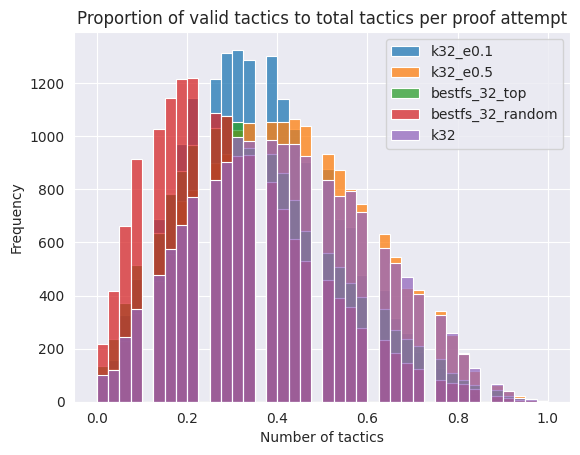

k32_e0.1 vs k32_e0.5: TtestResult(statistic=-31.667024509779814, pvalue=4.089210995845845e-217, df=36217.0)
k32_e0.1 vs bestfs_32_top: TtestResult(statistic=3.5577641110143197, pvalue=0.0003745389700040065, df=33657.0)
k32_e0.1 vs bestfs_32_random: TtestResult(statistic=31.79222049962962, pvalue=1.2289046047740993e-218, df=34378.0)
k32_e0.1 vs k32: TtestResult(statistic=-30.53715165545311, pvalue=3.5776683259528e-202, df=35348.0)
k32_e0.5 vs bestfs_32_top: TtestResult(statistic=32.10810040799891, pvalue=8.862363480810259e-223, df=33158.0)
k32_e0.5 vs bestfs_32_random: TtestResult(statistic=59.201113278582646, pvalue=0.0, df=33879.0)
k32_e0.5 vs k32: TtestResult(statistic=0.41633087752982095, pvalue=0.6771704649220586, df=34849.0)
bestfs_32_top vs bestfs_32_random: TtestResult(statistic=25.56591517085782, pvalue=1.0663949672196707e-142, df=31319.0)
bestfs_32_top vs k32: TtestResult(statistic=-31.00827907335392, pvalue=4.728761332575034e-208, df=32289.0)
bestfs_32_random vs k32: TtestRes

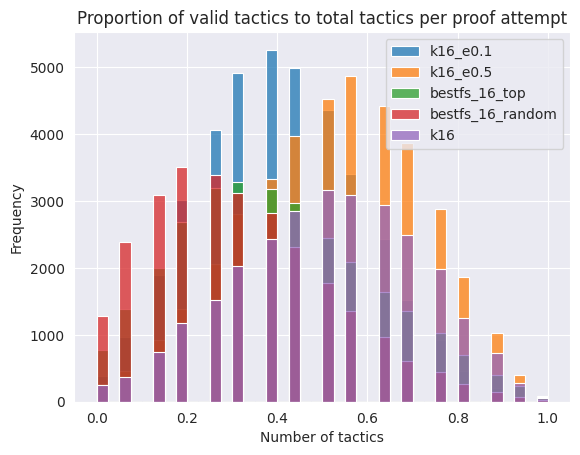

k16_e0.1 vs k16_e0.5: TtestResult(statistic=-87.08560038971927, pvalue=0.0, df=78010.0)
k16_e0.1 vs bestfs_16_top: TtestResult(statistic=6.200483964477796, pvalue=5.661085776143685e-10, df=68289.0)
k16_e0.1 vs bestfs_16_random: TtestResult(statistic=61.899319630544845, pvalue=0.0, df=66447.0)
k16_e0.1 vs k16: TtestResult(statistic=-71.19569959219635, pvalue=0.0, df=66249.0)
k16_e0.5 vs bestfs_16_top: TtestResult(statistic=79.99140821286456, pvalue=0.0, df=68559.0)
k16_e0.5 vs bestfs_16_random: TtestResult(statistic=134.07275877996642, pvalue=0.0, df=66717.0)
k16_e0.5 vs k16: TtestResult(statistic=7.140296702643353, pvalue=9.40791957632143e-13, df=66519.0)
bestfs_16_top vs bestfs_16_random: TtestResult(statistic=47.04067124133674, pvalue=0.0, df=56996.0)
bestfs_16_top vs k16: TtestResult(statistic=-65.66671590392679, pvalue=0.0, df=56798.0)
bestfs_16_random vs k16: TtestResult(statistic=-115.30305931782507, pvalue=0.0, df=54956.0)
k8_e0.1: 0.433 +/- 0.001
k8_e0.5: 0.565 +/- 0.001
bestfs

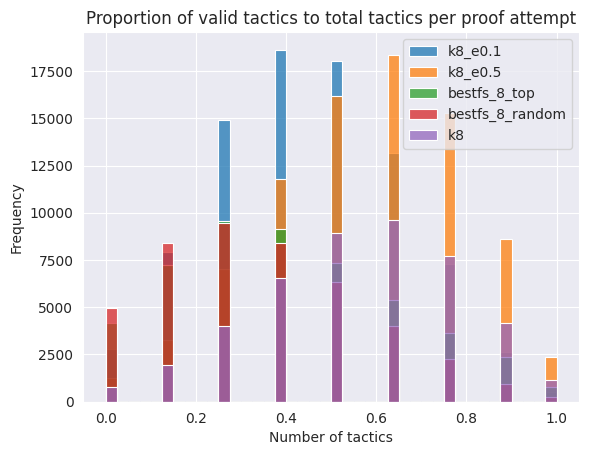

k8_e0.1 vs k8_e0.5: TtestResult(statistic=-125.5864023410954, pvalue=0.0, df=170055.0)
k8_e0.1 vs bestfs_8_top: TtestResult(statistic=34.187546816708895, pvalue=4.551014156979188e-255, df=135580.0)
k8_e0.1 vs bestfs_8_random: TtestResult(statistic=79.50267526682464, pvalue=0.0, df=131056.0)
k8_e0.1 vs k8: TtestResult(statistic=-95.05621878931969, pvalue=0.0, df=130776.0)
k8_e0.5 vs bestfs_8_top: TtestResult(statistic=133.65856946245535, pvalue=0.0, df=133873.0)
k8_e0.5 vs bestfs_8_random: TtestResult(statistic=178.1162853741489, pvalue=0.0, df=129349.0)
k8_e0.5 vs k8: TtestResult(statistic=9.762291044811613, pvalue=1.6638104626250814e-22, df=129069.0)
bestfs_8_top vs bestfs_8_random: TtestResult(statistic=36.58228611141347, pvalue=5.910336361223844e-291, df=94874.0)
bestfs_8_top vs k8: TtestResult(statistic=-105.61605731141964, pvalue=0.0, df=94594.0)
bestfs_8_random vs k8: TtestResult(statistic=-146.49722836109487, pvalue=0.0, df=90070.0)


In [69]:
chosen_paths = ['k32_e0.1', 'k32_e0.5', 'bestfs_32_top', 'bestfs_32_random', 'k32']
for p in chosen_paths:
    sns.histplot(data[p]['valid_tacs'], label=p, bins=40)
    print(f'{p}: {np.mean(data[p]["valid_tacs"]):.3f} +/- {sem(data[p]["valid_tacs"]):.3f}')

plt.legend()
plt.title('Proportion of valid tactics to total tactics per proof attempt')
plt.xlabel('Number of tactics')
plt.ylabel('Frequency')
plt.show()

for i in range(len(chosen_paths)):
    for j in range(i + 1, len(chosen_paths)):
        test = ttest_ind(data[chosen_paths[i]]['valid_tacs'], data[chosen_paths[j]]['valid_tacs'])

        print(f'{chosen_paths[i]} vs {chosen_paths[j]}: {test}')


chosen_paths = ['k16_e0.1', 'k16_e0.5', 'bestfs_16_top', 'bestfs_16_random', 'k16']
for p in chosen_paths:
    sns.histplot(data[p]['valid_tacs'], label=p, bins=40)
    print(f'{p}: {np.mean(data[p]["valid_tacs"]):.3f} +/- {sem(data[p]["valid_tacs"]):.3f}')

plt.legend()
plt.title('Proportion of valid tactics to total tactics per proof attempt')
plt.xlabel('Number of tactics')
plt.ylabel('Frequency')
plt.show()

for i in range(len(chosen_paths)):
    for j in range(i + 1, len(chosen_paths)):
        test = ttest_ind(data[chosen_paths[i]]['valid_tacs'], data[chosen_paths[j]]['valid_tacs'])

        print(f'{chosen_paths[i]} vs {chosen_paths[j]}: {test}')


chosen_paths = ['k8_e0.1', 'k8_e0.5', 'bestfs_8_top', 'bestfs_8_random', 'k8']
for p in chosen_paths:
    sns.histplot(data[p]['valid_tacs'], label=p, bins=40)
    print(f'{p}: {np.mean(data[p]["valid_tacs"]):.3f} +/- {sem(data[p]["valid_tacs"]):.3f}')

plt.legend()
plt.title('Proportion of valid tactics to total tactics per proof attempt')
plt.xlabel('Number of tactics')
plt.ylabel('Frequency')
plt.show()

for i in range(len(chosen_paths)):
    for j in range(i + 1, len(chosen_paths)):
        test = ttest_ind(data[chosen_paths[i]]['valid_tacs'], data[chosen_paths[j]]['valid_tacs'])
        print(f'{chosen_paths[i]} vs {chosen_paths[j]}: {test}')





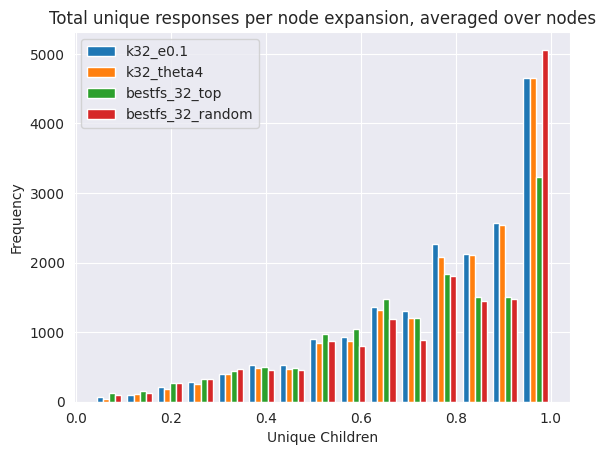

k32_e0.1: 0.769 +/- 0.002
k32_theta4: 0.775 +/- 0.002
bestfs_32_top: 0.723 +/- 0.002
bestfs_32_random: 0.763 +/- 0.002
k32_e0.1 vs k32_theta4: TtestResult(statistic=-2.7244125886587964, pvalue=0.00644472433122476, df=35796.0)
k32_e0.1 vs bestfs_32_top: TtestResult(statistic=18.79503035729046, pvalue=2.1106154551290962e-78, df=33351.0)
k32_e0.1 vs bestfs_32_random: TtestResult(statistic=2.524952816350681, pvalue=0.011575893217588116, df=33986.0)
k32_theta4 vs bestfs_32_top: TtestResult(statistic=21.184156262605164, pvalue=6.196973202491946e-99, df=32677.0)
k32_theta4 vs bestfs_32_random: TtestResult(statistic=5.005875700991854, pvalue=5.589187542809812e-07, df=33312.0)
bestfs_32_top vs bestfs_32_random: TtestResult(statistic=-14.91357370658965, pvalue=4.0217978523326275e-50, df=30867.0)


In [37]:


chosen_paths = ['k32_e0.1', 'k32_theta4', 'bestfs_32_top', 'bestfs_32_random']
# chosen_paths = ['k16_e0.1', 'k16_theta4', 'bestfs_16_top', 'bestfs_16_random']
# chosen_paths = ['k8_e0.1', 'k8_theta4', 'bestfs_8_top', 'bestfs_8_random']


for p in chosen_paths:
    data[p]['unique_children'] = [x for x in data[p]['unique_children'] if not np.isnan(x)]


plt.hist([data[p]['unique_children'] for p in chosen_paths], bins=15)


plt.legend(chosen_paths)
plt.title('Total unique responses per node expansion, averaged over nodes')
plt.xlabel('Unique Children')
plt.ylabel('Frequency')
plt.show()

# print mean and std
for p in chosen_paths:
    print(f'{p}: {np.nanmean(data[p]["unique_children"]):.3f} +/- { sem(data[p]["unique_children"]):.3f}')

for i in range(len(chosen_paths)):
    for j in range(i + 1, len(chosen_paths)):
        # test = ttest_ind(data[chosen_paths[i]]['unique_children'], data[chosen_paths[j]]['unique_children'])
        test = ttest_ind(data[chosen_paths[i]]['unique_children'], data[chosen_paths[j]]['unique_children'])
        
        print(f'{chosen_paths[i]} vs {chosen_paths[j]}: {test}')





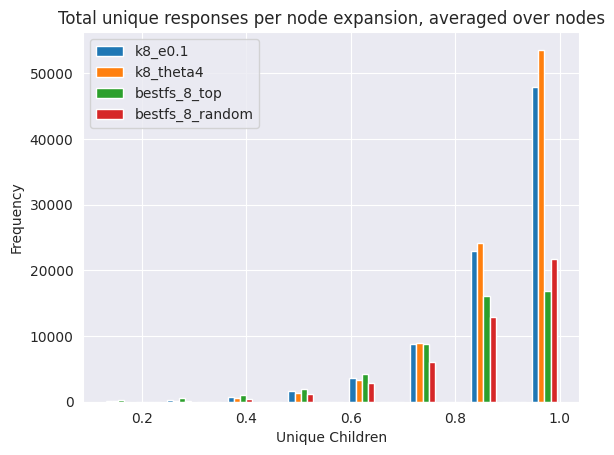

k8_e0.1: 0.908 +/- 0.000
k8_theta4: 0.917 +/- 0.000
bestfs_8_top: 0.839 +/- 0.001
bestfs_8_random: 0.886 +/- 0.001
k8_e0.1 vs k8_theta4: TtestResult(statistic=-14.98828168114254, pvalue=9.408167303980416e-51, df=177888.0)
k8_e0.1 vs bestfs_8_top: TtestResult(statistic=81.5707474957415, pvalue=0.0, df=135497.0)
k8_e0.1 vs bestfs_8_random: TtestResult(statistic=27.110591137196064, pvalue=2.067904471986331e-161, df=131050.0)
k8_theta4 vs bestfs_8_top: TtestResult(statistic=97.96408571503773, pvalue=0.0, df=141631.0)
k8_theta4 vs bestfs_8_random: TtestResult(statistic=41.107214686725804, pvalue=0.0, df=137184.0)
bestfs_8_top vs bestfs_8_random: TtestResult(statistic=-45.43089420678513, pvalue=0.0, df=94793.0)


In [34]:
from scipy.stats import ttest_ind

# chosen_paths = ['k32_e0.1', 'k32_theta4', 'bestfs_32_top', 'bestfs_32_random']
# chosen_paths = ['k16_e0.1', 'k16_theta4', 'bestfs_16_top', 'bestfs_16_random']
chosen_paths = ['k8_e0.1', 'k8_theta4', 'bestfs_8_top', 'bestfs_8_random']


# for p in chosen_paths:
#     data[p]['total_unique_resposes'] = [x / 16 for x in data[p]['total_unique_resposes'] if not np.isnan(x)] (run once for k16, similar for k32/k8, to get ratio rather than absolute)


plt.hist([data[p]['total_unique_responses'] for p in chosen_paths], bins=15)


plt.legend(chosen_paths)
# plt.title('Proportion of unique children to valid children per proof attempt, averaged over nodes')
plt.title('Total unique responses per node expansion, averaged over nodes')
plt.xlabel('Unique Children')
plt.ylabel('Frequency')
plt.show()

# print mean and std
for p in chosen_paths:
    print(f'{p}: {np.nanmean(data[p]["total_unique_responses"]):.3f} +/- { sem(data[p]["total_unique_responses"]):.3f}')

for i in range(len(chosen_paths)):
    for j in range(i + 1, len(chosen_paths)):
        # test = ttest_ind(data[chosen_paths[i]]['total_unique_responses'], data[chosen_paths[j]]['total_unique_responses'])
        test = ttest_ind(data[chosen_paths[i]]['total_unique_responses'], data[chosen_paths[j]]['total_unique_responses'])
        
        print(f'{chosen_paths[i]} vs {chosen_paths[j]}: {test}')





In [26]:

chosen_paths = ['k8_e0.1', 'k8_t1', 'bestfs_8_top', 'bestfs_8_random']
# chosen_paths = ['k32_e0.1', 'bestfs_32_top', 'bestfs_32_random', 'k32_t1']
# chosen_paths = ['k16_e0.1', 'bestfs_16_top', 'bestfs_16_random', 'k16_t1']

for p in chosen_paths:
    data[p]['tactic_times'] = [x for x in data[p]['tactic_times'] if not np.isnan(x)]
    
for p in chosen_paths:
    print(f'{p}: {np.nanmean(data[p]["tactic_times"]):.3f} +/- {sem(data[p]["tactic_times"])}')


k8_e0.1: 0.155 +/- 0.0005049809036701249
k8_t1: 0.136 +/- 0.00045377672181688895
bestfs_8_top: 0.206 +/- 0.0008224200800269907
bestfs_8_random: 0.198 +/- 0.0008980289210317575


In [2]:

for p in chosen_paths:
    sns.histplot(data[p]['tactic_times'], label=p)

plt.title('Tactic generation time (averaged over nodes)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency')
plt.xlim(0, 2.5)
plt.legend()
plt.show()